In [1]:
import pandas as pd
import numpy as np

#import acquire
#import prepare

import seaborn as sns
import matplotlib.pyplot as plt 


import wrangle as w
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = w.get_zillow_data()
df.head()

,yearbuilt,lotsizesquarefeet,logerror,longitude,latitude,transactiondate,bathroomcnt,bedroomcnt,fips,calculatedfinishedsquarefeet,regionidzip,taxvaluedollarcnt
0,1940.0,6750.0,0.279112,-118388723.0,34182197.0,2017-01-10,1.0,3.0,6037.0,1114.0,96451.0,330387.0
1,1936.0,8098.0,0.158130,-118398122.0,34180389.0,2017-01-10,3.0,3.0,6037.0,2479.0,96451.0,174155.0
2,1956.0,6049.0,-0.019678,-118402898.0,34181471.0,2017-01-10,2.0,3.0,6037.0,1566.0,96451.0,534455.0
3,1949.0,9411.0,0.005471,-118410984.0,34182042.0,2017-01-10,1.0,2.0,6037.0,1287.0,96451.0,330938.0
4,1948.0,7181.0,0.089711,-118407191.0,34181941.0,2017-01-10,1.0,3.0,6037.0,1706.0,96451.0,440099.0


In [3]:
df.shape

(56079, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56079 entries, 0 to 56078
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   yearbuilt                     55830 non-null  float64
 1   lotsizesquarefeet             55729 non-null  float64
 2   logerror                      56079 non-null  float64
 3   longitude                     56079 non-null  float64
 4   latitude                      56079 non-null  float64
 5   transactiondate               56079 non-null  object 
 6   bathroomcnt                   56079 non-null  float64
 7   bedroomcnt                    56079 non-null  float64
 8   fips                          56079 non-null  float64
 9   calculatedfinishedsquarefeet  55848 non-null  float64
 10  regionidzip                   55979 non-null  float64
 11  taxvaluedollarcnt             56071 non-null  float64
dtypes: float64(11), object(1)
memory usage: 5.1+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
yearbuilt,55830.0,1.961186e+03,21.995171,1.862000e+03,1.949000e+03,1.958000e+03,1.976000e+03,2.016000e+03
lotsizesquarefeet,55729.0,1.155687e+04,91360.331779,1.670000e+02,5.687000e+03,6.803000e+03,8.641000e+03,6.971010e+06
logerror,56079.0,1.689115e-02,0.172738,-4.655420e+00,-2.437695e-02,6.771479e-03,3.952815e-02,5.262999e+00
longitude,56079.0,-1.182070e+08,352784.299142,-1.194484e+08,-1.184038e+08,-1.181606e+08,-1.179498e+08,-1.175559e+08
latitude,56079.0,3.401649e+07,248995.171669,3.334071e+07,3.383689e+07,3.401856e+07,3.418135e+07,3.480695e+07
bathroomcnt,56079.0,2.239457e+00,1.007012,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
bedroomcnt,56079.0,3.289110e+00,0.958756,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
fips,56079.0,6.048842e+03,21.237610,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
calculatedfinishedsquarefeet,55848.0,1.868286e+03,966.973076,2.000000e+01,1.260000e+03,1.630000e+03,2.217000e+03,2.634500e+04
regionidzip,55979.0,9.659910e+04,4456.313124,9.598200e+04,9.619300e+04,9.638900e+04,9.698700e+04,3.996750e+05


In [6]:
df = df.rename(columns={'bedroomcnt':'bedrooms', 
                   'bathroomcnt':'bathrooms',
                   'calculatedfinishedsquarefeet':'sqft',
                   'yearbuilt':'year_built',
                   'longitude':'long',
                   'latitude': 'lat',
                   'transactiondate': 'transaction_month',
                   'lotsizesquarefeet': 'lot_sqft',
                   'taxvaluedollarcnt':'home_value'})

In [7]:
df

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,regionidzip,home_value
0,1940.0,6750.0,0.279112,-118388723.0,34182197.0,2017-01-10,1.0,3.0,6037.0,1114.0,96451.0,330387.0
1,1936.0,8098.0,0.158130,-118398122.0,34180389.0,2017-01-10,3.0,3.0,6037.0,2479.0,96451.0,174155.0
2,1956.0,6049.0,-0.019678,-118402898.0,34181471.0,2017-01-10,2.0,3.0,6037.0,1566.0,96451.0,534455.0
3,1949.0,9411.0,0.005471,-118410984.0,34182042.0,2017-01-10,1.0,2.0,6037.0,1287.0,96451.0,330938.0
4,1948.0,7181.0,0.089711,-118407191.0,34181941.0,2017-01-10,1.0,3.0,6037.0,1706.0,96451.0,440099.0
...,...,...,...,...,...,...,...,...,...,...,...,...
56074,1954.0,7505.0,0.003785,-118399073.0,34233216.0,2017-09-15,1.0,3.0,6037.0,999.0,96375.0,222136.0
56075,1958.0,8339.0,0.062060,-118400541.0,34234902.0,2017-09-15,2.0,3.0,6037.0,1366.0,96375.0,211616.0
56076,1973.0,7499.0,0.029647,-118421360.0,34227043.0,2017-09-15,3.0,4.0,6037.0,2180.0,96411.0,538107.0
56077,1954.0,6068.0,0.040940,-118419411.0,34229157.0,2017-09-15,2.0,3.0,6037.0,1570.0,96361.0,368839.0


In [8]:
df['transaction_month'] = df['transaction_month'].str.replace("-", "").astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56079 entries, 0 to 56078
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year_built         55830 non-null  float64
 1   lot_sqft           55729 non-null  float64
 2   logerror           56079 non-null  float64
 3   long               56079 non-null  float64
 4   lat                56079 non-null  float64
 5   transaction_month  56079 non-null  float64
 6   bathrooms          56079 non-null  float64
 7   bedrooms           56079 non-null  float64
 8   fips               56079 non-null  float64
 9   sqft               55848 non-null  float64
 10  regionidzip        55979 non-null  float64
 11  home_value         56071 non-null  float64
dtypes: float64(12)
memory usage: 5.1 MB


In [10]:
df['transaction_month']

0        20170110.0
1        20170110.0
2        20170110.0
3        20170110.0
4        20170110.0
            ...    
56074    20170915.0
56075    20170915.0
56076    20170915.0
56077    20170915.0
56078    20170915.0
Name: transaction_month, Length: 56079, dtype: float64

In [11]:
df['transaction_month']= df['transaction_month'].astype(str).str[4:6].astype(int)

In [12]:
df.transaction_month.value_counts()

5    8409
8    7677
6    7666
7    6853
3    6336
4    6126
2    5068
1    5011
9    2933
Name: transaction_month, dtype: int64

In [13]:
df['fips'].value_counts()

6037.0    37287
6059.0    13972
6111.0     4820
Name: fips, dtype: int64

In [14]:
df.isna().sum()

year_built           249
lot_sqft             350
logerror               0
long                   0
lat                    0
transaction_month      0
bathrooms              0
bedrooms               0
fips                   0
sqft                 231
regionidzip          100
home_value             8
dtype: int64

In [15]:
df = df.dropna()

In [16]:
df.isna().sum()

year_built           0
lot_sqft             0
logerror             0
long                 0
lat                  0
transaction_month    0
bathrooms            0
bedrooms             0
fips                 0
sqft                 0
regionidzip          0
home_value           0
dtype: int64

In [17]:
df.bedrooms.value_counts()

3.0     24900
4.0     16474
2.0      8671
5.0      3938
6.0       644
1.0       565
0.0       122
7.0       109
8.0        33
9.0         8
25.0        1
10.0        1
11.0        1
Name: bedrooms, dtype: int64

In [18]:
df.bathrooms.value_counts()

2.0     24445
3.0     11049
1.0     10564
2.5      3714
4.0      2101
1.5       791
5.0       762
3.5       723
4.5       497
6.0       293
5.5       163
0.0       131
7.0       111
8.0        35
6.5        30
9.0        25
10.0       11
7.5        11
8.5         4
11.0        3
13.0        1
9.5         1
20.0        1
19.5        1
Name: bathrooms, dtype: int64

In [19]:
len(df[df.sqft > 10_000])

50

In [26]:
df = w.clean_zillow_data(df)

In [27]:
df.bedrooms.value_counts()

3.0    24724
4.0    16126
2.0     8643
5.0     3638
1.0      559
6.0      495
Name: bedrooms, dtype: int64

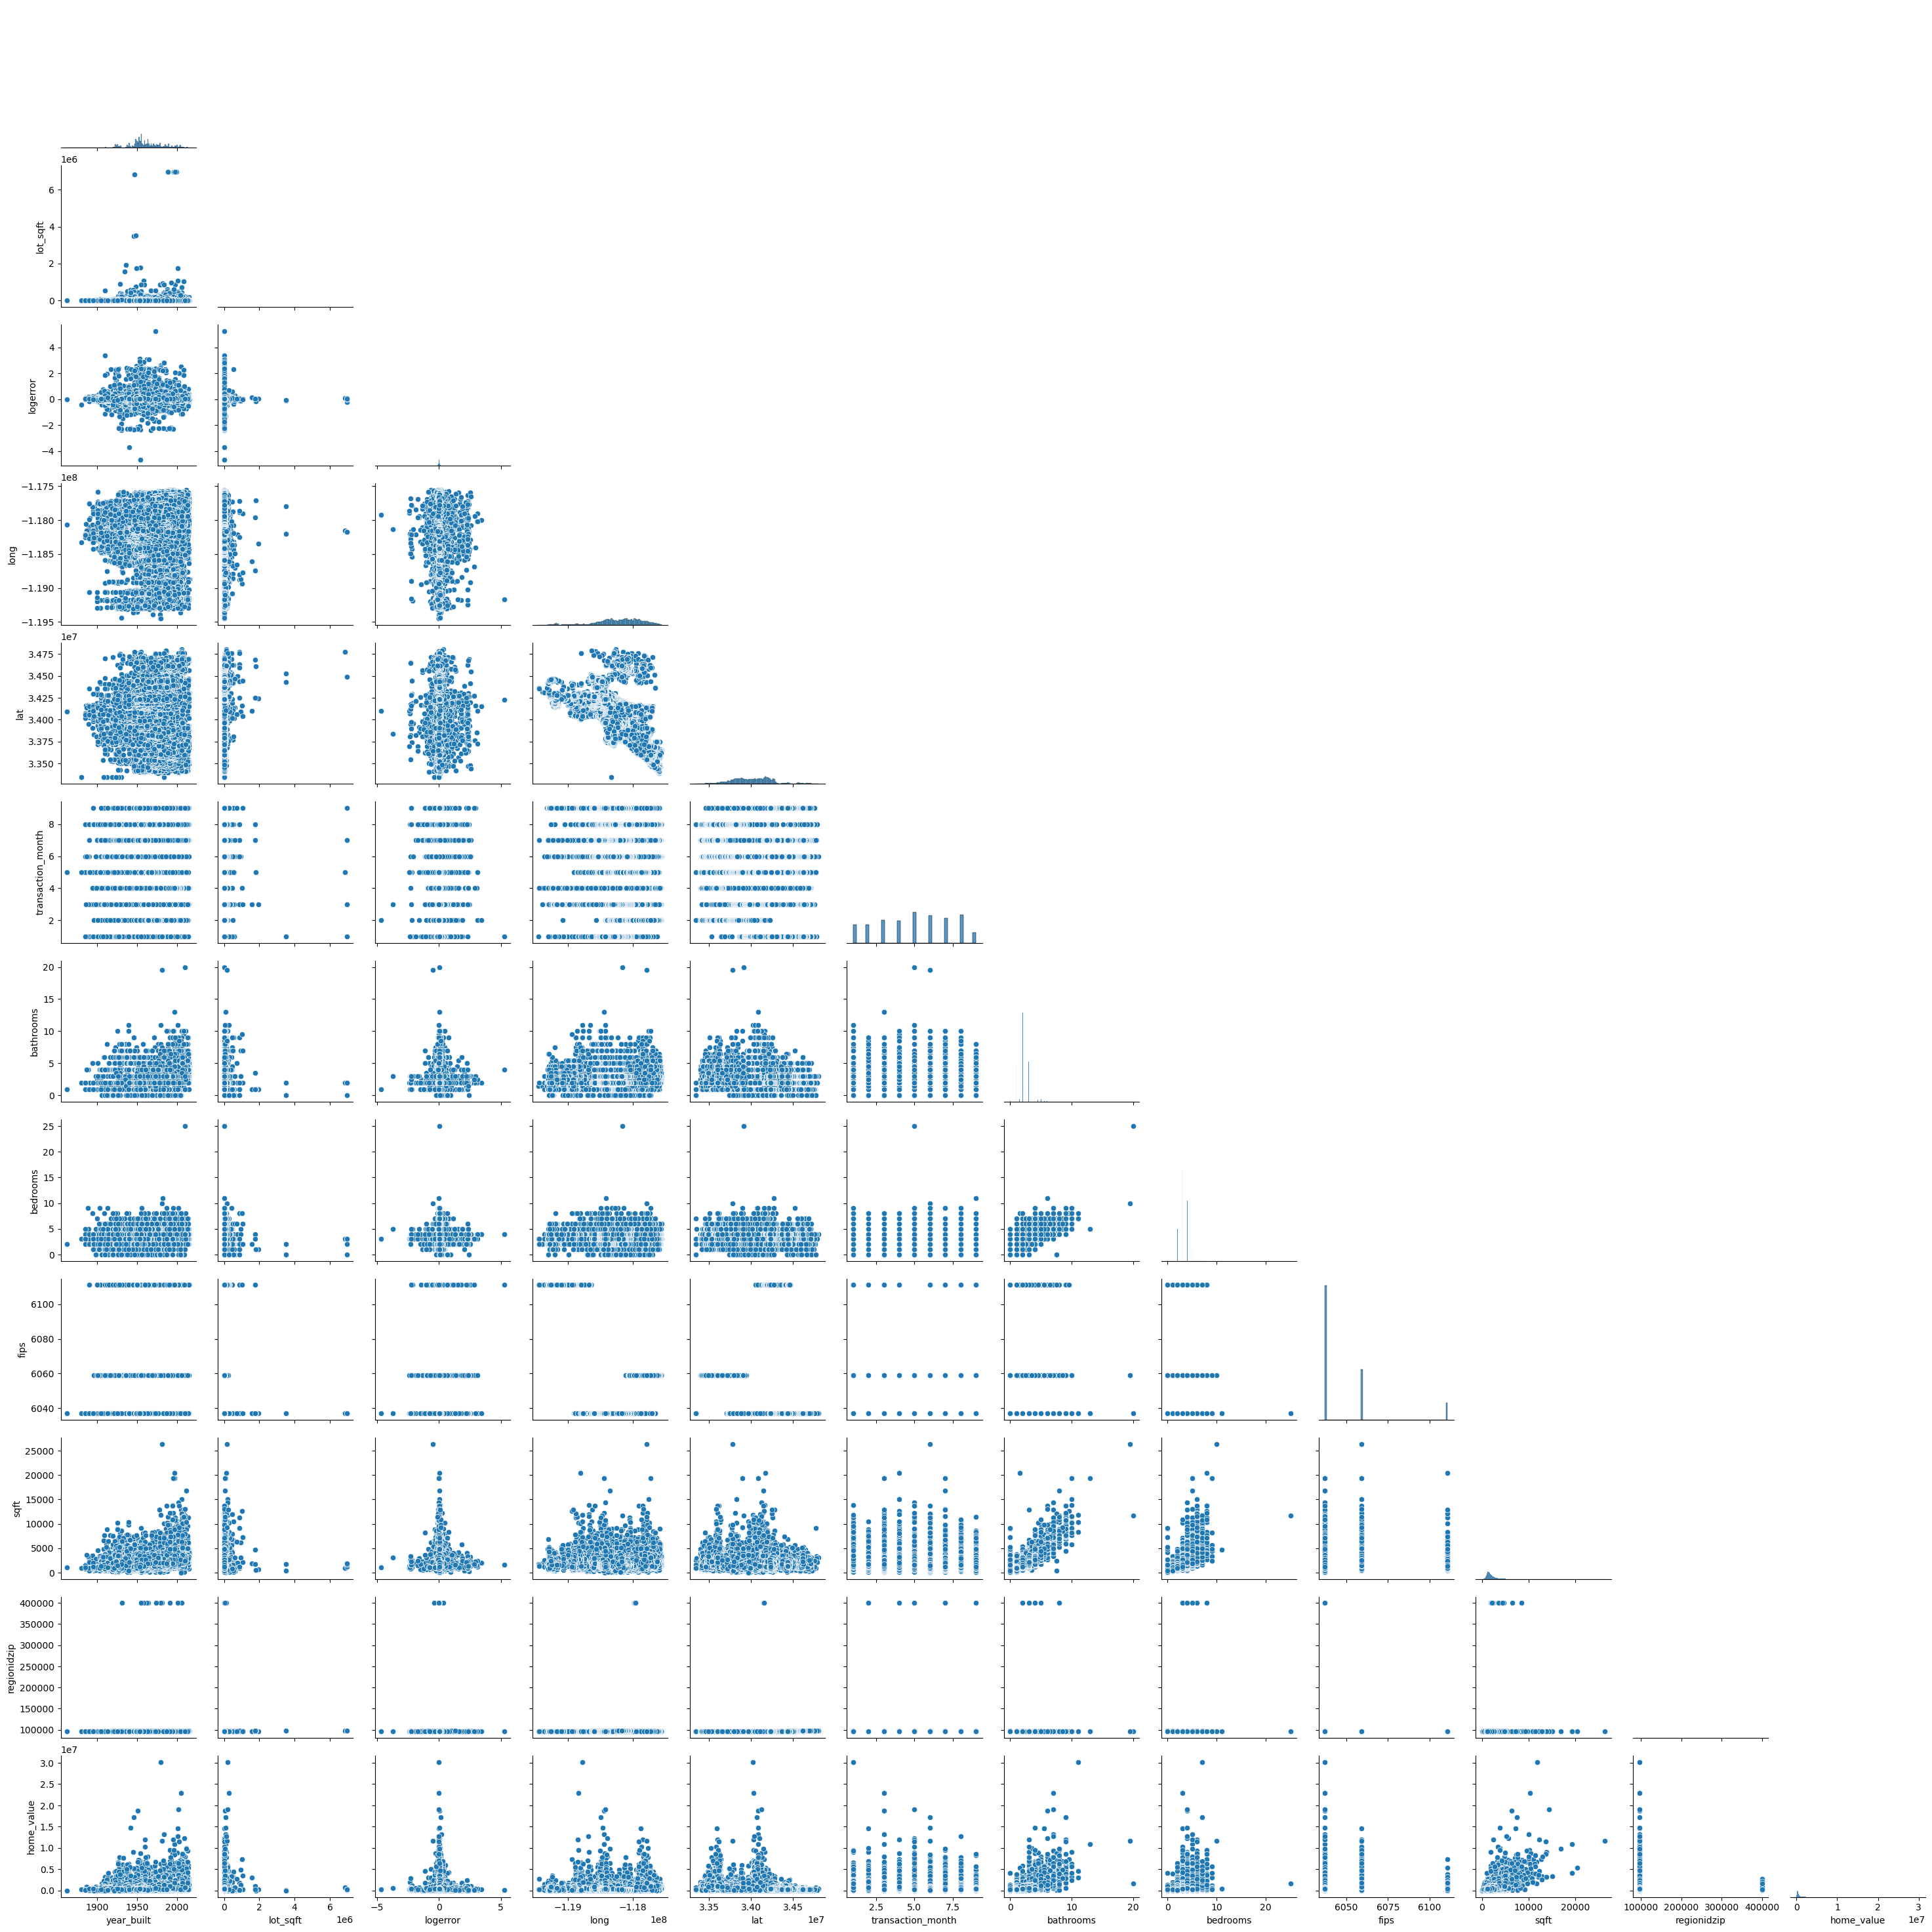

In [21]:
sns.pairplot(df, corner=True)
plt.show()

In [22]:
la_county = df['fips'] == 6037
ventura_county = df['fips'] == 6111
orange_county = df['fips'] == 6059

In [23]:
df[la_county]['home_value'].mean()

429284.0289980758

In [24]:
df[ventura_county]['home_value'].mean()

432784.8760050783

In [25]:
df[orange_county]['home_value'].mean()

528885.5702210664